In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
#mounting the dataset from drive
# from google.colab import drive
# drive.mount('/content/gdrive') 

#connecting to sqlite db
con = sqlite3.connect('database.sqlite')
                      
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
# Removing duplicate reviews
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

(364173, 10)


In [7]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [10]:
final["cleanReview"] = final["Summary"].map(str) + ". " + final["Text"]
final['cleanReview'].head()

0    Good Quality Dog Food. I have bought several o...
1    Not as Advertised. Product arrived labeled as ...
2    "Delight" says it all. This is a confection th...
3    Cough Medicine. If you are looking for the sec...
4    Great taffy. Great taffy at a great price.  Th...
Name: cleanReview, dtype: object

In [11]:
final['lengthOfReview'] = final['cleanReview'].str.split().str.len()
final['lengthOfReview'].head()

0    52
1    34
2    98
3    43
4    29
Name: lengthOfReview, dtype: int64

In [10]:
#remove urls from text python
from tqdm import tqdm
lst = []
removed_urls_list = []
for text in tqdm(final['Text']):
  removed_urls_text = re.sub(r"http\S+", "", text)
  lst.append(removed_urls_text)

100%|██████████| 364171/364171 [00:00<00:00, 447313.57it/s]


In [11]:
#remove urls from text python
removed_urls_list = []
for text in tqdm(lst):
  removed_urls_text = re.sub(r"http\S+", "", text)
  removed_urls_list.append(removed_urls_text)

100%|██████████| 364171/364171 [00:00<00:00, 452270.97it/s]


In [12]:
from bs4 import BeautifulSoup
text_lst = []
for text in tqdm(removed_urls_list):
  soup = BeautifulSoup(text, 'lxml')
  text = soup.get_text()
  text_lst.append(text)
# print(text)
# print("="*50)

100%|██████████| 364171/364171 [01:49<00:00, 3330.00it/s]


In [13]:
print(len(final['Text']))

364171


In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
decat_lst = []
for decat_text in tqdm(text_lst):
  text = decontracted(decat_text)
  decat_lst.append(text)

100%|██████████| 364171/364171 [00:05<00:00, 65510.16it/s]


In [16]:
strip_list = []
for to_strip in tqdm(decat_lst):
  text = re.sub("\S*\d\S*", "", to_strip).strip()
  strip_list.append(text)

100%|██████████| 364171/364171 [00:22<00:00, 16465.51it/s]


In [17]:
spatial_list = []
for to_spatial in tqdm(strip_list):
  text = re.sub('[^A-Za-z0-9]+', ' ', to_spatial)
  spatial_list.append(text)

100%|██████████| 364171/364171 [00:12<00:00, 29401.19it/s]


In [18]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(spatial_list):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:44<00:00, 2216.92it/s]


In [20]:
print(len(preprocessed_reviews))
preprocessed_reviews[-1]

364171


'satisfied product advertised use cereal raw vinegar general sweetner'

In [21]:
final['Preprocessed_text'] = preprocessed_reviews

In [22]:
print(len(final))
final.tail(5)

364171


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_text
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,1,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,great sesame chicken good not better resturant...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,disappointed flavor chocolate notes especially...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,1,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",stars small give one training session tried tr...
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,1,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,best treats training rewarding dog good groomi...
525813,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,1,1338422400,Great Honey,"I am very satisfied ,product is as advertised,...",satisfied product advertised use cereal raw vi...


In [93]:
dir_path = os.getcwd()
conn = sqlite3.connect(os.path.join(dir_path, 'final.sqlite'))
# final.to_sql('Reviews', conn, if_exists='replace', index=False)

In [94]:
review_3 = pd.read_sql_query(""" SELECT count(*) FROM Reviews""", conn)
print(review_3)

   count(*)
0    364171


In [95]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews""", conn)

In [96]:
filtered_data.shape

(364171, 12)

In [97]:
filtered_data["Time"] = pd.to_datetime(filtered_data["Time"], unit = "s")
filtered_data = filtered_data.sort_values(by = "Time")

In [98]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanReview,lengthOfReview
117924,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,every book educational witty little book makes...,38
117901,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,whole series great way spend time child rememb...,39
298792,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,entertainingl funny beetlejuice well written m...,15
169281,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",modern day fairy tale twist rumplestiskin capt...,25
298791,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,fantastic beetlejuice excellent funny movie ke...,26


In [99]:
print(len(filtered_data))
filtered_data.info()
filtered_data = filtered_data.head(100000)
print(len(filtered_data))

364171
<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 117924 to 107253
Data columns (total 12 columns):
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null int64
Time                      364171 non-null datetime64[ns]
Summary                   364171 non-null object
Text                      364171 non-null object
cleanReview               364171 non-null object
lengthOfReview            364171 non-null int64
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 36.1+ MB
100000


In [100]:
filtered_data['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [101]:
X = filtered_data["cleanReview"]
print(print("shape of X:", X.head(5)))
y = filtered_data["Score"]
print("shape of y:", y.head(5))
X_len = filtered_data['lengthOfReview']

shape of X: 117924    every book educational witty little book makes...
117901    whole series great way spend time child rememb...
298792    entertainingl funny beetlejuice well written m...
169281    modern day fairy tale twist rumplestiskin capt...
298791    fantastic beetlejuice excellent funny movie ke...
Name: cleanReview, dtype: object
None
shape of y: 117924    1
117901    1
298792    1
169281    1
298791    1
Name: Score, dtype: int64


In [102]:
len(filtered_data['lengthOfReview'])

100000

In [103]:
X_train = X[0:60000]
Y_train = y[0:60000]
X_val = X[60000:80000]
Y_val = y[60000:80000]
X_test = X[80000:100000]
Y_test = y[80000:100000]

In [104]:
print(len(X_train), len(X_test), len(X_val))
print(len(Y_train), len(Y_test), len(Y_val))

60000 20000 20000
60000 20000 20000


# [4.1] BAG OF WORDS

In [24]:
from sklearn.feature_extraction.text import CountVectorizer 

count_vect = CountVectorizer()
X_train_vect = count_vect.fit_transform(X_train)
X_test_vect = count_vect.transform(X_test)
X_val_vect = count_vect.transform(X_val)
feature_names = count_vect.get_feature_names()
# BoW_dict = {'X_train_vect':X_train_vect, 'X_test_vect': X_test_vect, 'X_val_vect': X_val_vect}
print(X_train_vect.shape)
# print(feature_names)

(60000, 47535)


In [25]:
X_train_vect.shape

(60000, 47535)

In [26]:
len(final['lengthOfReview'])

364171

In [27]:
from scipy.sparse import hstack
# len_review = final['lengthOfReview'].to_sparse()
concat_data = hstack((X_train_vect,np.array(final['lengthOfReview'][0:60000])[:,None]))
concat_data_val = hstack((X_val_vect,np.array(final['lengthOfReview'][60000:80000])[:,None]))
concat_data_test = hstack((X_test_vect,np.array(final['lengthOfReview'][80000:100000])[:,None]))

In [28]:
print(concat_data.shape)
print(concat_data_val.shape)
print(concat_data_test.shape)

(60000, 47536)
(20000, 47536)
(20000, 47536)


In [29]:
print(len(feature_names))

47535


In [30]:
BoW_dict = {'X_train_vect':concat_data, 'X_test_vect': concat_data_test, 'X_val_vect': concat_data_val}
print(BoW_dict['X_train_vect'].shape)

(60000, 47536)


In [ ]:
import pickle
with open('BoW.pkl', 'wb') as handle:
    pickle.dump(BoW_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
train_tf_idf = tf_idf_vect.fit_transform(X_train)
cv_tf_idf = tf_idf_vect.transform(X_val)
test_tf_idf = tf_idf_vect.transform(X_test)

print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the type of count vectorizer ",type(train_tf_idf))
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])

the shape of out text TFIDF vectorizer  (60000, 35873)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words including both unigrams and bigrams  35873


In [32]:
tfidf_concat_data_train = hstack((train_tf_idf,np.array(final['lengthOfReview'][0:60000])[:,None]))
tfidf_concat_data_val = hstack((cv_tf_idf,np.array(final['lengthOfReview'][60000:80000])[:,None]))
tfidf_concat_data_test = hstack((test_tf_idf,np.array(final['lengthOfReview'][80000:100000])[:,None]))

In [33]:
tf_idf_dict = {'train_tf_idf': tfidf_concat_data_train, 'cv_tf_idf': tfidf_concat_data_val, 'test_tf_idf': tfidf_concat_data_test}

In [ ]:
import pickle
with open('tf_idf.pkl', 'wb') as handle:
    pickle.dump(tf_idf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.4] Word2Vec

In [34]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sen=[]
for sentance in X_train:
    list_of_sen.append(sentance.split())

In [35]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sen,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8565828204154968), ('excellent', 0.8381140828132629), ('fantastic', 0.8366681337356567), ('awesome', 0.7857832908630371), ('wonderful', 0.7829444408416748), ('good', 0.742619514465332), ('perfect', 0.7174795866012573), ('nice', 0.6593438386917114), ('fabulous', 0.6570981740951538), ('incredible', 0.6524804830551147)]
[('greatest', 0.7822151780128479), ('best', 0.7523022294044495), ('tastiest', 0.6484744548797607), ('coolest', 0.6170215606689453), ('terrible', 0.6128978729248047), ('awful', 0.6031897664070129), ('nicest', 0.5984950661659241), ('nastiest', 0.5957451462745667), ('closest', 0.5847468376159668), ('softest', 0.5774857401847839)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15289
sample words  ['flat', 'mater', 'elements', 'crock', 'tripe', 'reversed', 'lactaid', 'capsule', 'easiest', 'clarify', 'pees', 'swore', 'similiar', 'powdery', 'cement', 'deb', 'burned', 'seasonally', 'stove', 'reinforcement', 'confusion', 'sky', 'mama', 'evil', 'contrast', 'start', 'booklet', 'moves', 'chestnuts', 'virtuous', 'monitors', 'twain', 'liquified', 'recommendations', 'quinoa', 'micro', 'corned', 'celebrated', 'pitcher', 'clip', 'movie', 'hfcs', 'single', 'leftover', 'inhaled', 'impulse', 'leak', 'gag', 'farming', 'brazilian']


# [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

# [4.4.1.1] Avg W2v

In [37]:
print(X_train[117924])
print(len(X_val))
print(len(X_test))

every book educational witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college
20000
20000


In [38]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2vec(sentences_received):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(sentences_received): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [39]:
print(len([sent.split() for sent in X_test]))

20000


In [22]:
avg_w2v_train = avg_w2vec([sent.split() for sent in X_train])
avg_w2v_cv = avg_w2vec([sent.split() for sent in X_val])
avg_w2v_test = avg_w2vec([sent.split() for sent in X_test])

In [ ]:
Avg_w2v_dict = {'X_train_avgw2v':avg_w2v_train, 'Y_train_avgw2v': Y_train,  
                     'X_val_avgw2v': avg_w2v_cv, 'Y_val_avgw2v': Y_val,
                    'X_test_avgw2v': avg_w2v_test, 'Y_test_avgw2v': Y_test}

In [ ]:
import pickle
with open('/content/gdrive/My Drive/Colab Notebooks/Assignment 3/avg_w2v.pkl', 'wb') as handle:
    pickle.dump(Avg_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.4.1.2] TFIDF weighted W2v

In [79]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def tfidf_w2v(sentences_received):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(sentences_received): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        
    return tfidf_sent_vectors

In [73]:
tfidf_w2v_train = tfidf_w2v([sent.split() for sent in X_train])
tfidf_w2v_cv = tfidf_w2v([sent.split() for sent in X_val])
tfidf_w2v_test = tfidf_w2v([sent.split() for sent in X_test])

In [74]:
tfidf_w2v_dict = {'X_train_tfidfw2v':tfidf_w2v_train, 'Y_train_tfidfw2v': Y_train,  
                     'X_val_tfidfw2v': tfidf_w2v_cv, 'Y_val_tfidfw2v': Y_val,
                    'X_test_tfidfw2v': tfidf_w2v_test, 'Y_test_tfidfw2v': Y_test}

In [75]:
with open('tfidf_w2v.pkl', 'wb') as handle:
    pickle.dump(tfidf_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Logistic Regression on BoW

In [105]:
import pickle
with open(r"BoW.pkl", "rb") as input_file:
    BoW_dict = pickle.load(input_file)

In [106]:
#Applying Logistic Regression with L1 regularization on BOW
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

bow_lgr_train_score_list = []
bow_lgr_val_score_list = []
for c_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    bow_lgr=LogisticRegression(C=c_value, penalty='l1')
    bow_lgr.fit(BoW_dict['X_train_vect'],Y_train)
    
    bow_lgr_train_score = bow_lgr.score(BoW_dict['X_train_vect'], Y_train)
    bow_lgr_train_score_list.append(bow_lgr_train_score)
    bow_lgr_val_score = bow_lgr.score(BoW_dict['X_val_vect'], Y_val)
    bow_lgr_val_score_list.append(bow_lgr_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
bow_train_score = dict(zip(c_all, bow_lgr_train_score_list))
bow_val_score = dict(zip(c_all, bow_lgr_val_score_list))
print(bow_train_score)
print(bow_val_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.81s/it]


{0.1: 0.94340000000000002, 1: 0.97483333333333333, 100: 0.99985000000000002, 1000: 1.0, 0.0001: 0.8858166666666667, 10: 0.99819999999999998, 0.01: 0.90663333333333329, 0.001: 0.88551666666666662}
{0.1: 0.92884999999999995, 1: 0.93469999999999998, 100: 0.91590000000000005, 1000: 0.91110000000000002, 0.0001: 0.86280000000000001, 10: 0.92669999999999997, 0.01: 0.89124999999999999, 0.001: 0.86285000000000001}


In [107]:
#Weight Vector
print(bow_lgr.coef_)
print(type(bow_lgr.coef_))
weight_vector_bow = bow_lgr.coef_

[[-0.04214747  1.98158938  0.         ...,  0.          0.          0.01309713]]
<class 'numpy.ndarray'>


In [108]:
non_zero = np.count_nonzero(weight_vector_bow)
total_val = np.product(weight_vector_bow.shape)
bow_sparsity = (total_val - non_zero) / total_val
bow_sparsity

0.79836334567485701

In [89]:
#Applying Logistic Regression with L2 regularization on BOW
bow_lgr_train_score_list = []
bow_lgr_val_score_list = []
for c_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    bow_lgr=LogisticRegression(C=c_value, penalty='l2')
    bow_lgr.fit(BoW_dict['X_train_vect'],Y_train)
    
    bow_lgr_train_score = bow_lgr.score(BoW_dict['X_train_vect'], Y_train)
    bow_lgr_train_score_list.append(bow_lgr_train_score)
    bow_lgr_val_score = bow_lgr.score(BoW_dict['X_val_vect'], Y_val)
    bow_lgr_val_score_list.append(bow_lgr_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
bow_train_score = dict(zip(c_all, bow_lgr_train_score_list))
bow_val_score = dict(zip(c_all, bow_lgr_val_score_list))
print(bow_train_score)
print(bow_val_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:53<00:00,  6.72s/it]


{0.1: 0.96260000000000001, 1: 0.98463333333333336, 100: 0.99660000000000004, 1000: 0.99798333333333333, 0.0001: 0.88598333333333334, 10: 0.99598333333333333, 0.01: 0.93653333333333333, 0.001: 0.90013333333333334}
{0.1: 0.93654999999999999, 1: 0.93674999999999997, 100: 0.92984999999999995, 1000: 0.92710000000000004, 0.0001: 0.8629, 10: 0.93100000000000005, 0.01: 0.92000000000000004, 0.001: 0.8821}


In [179]:
# Pertubation Test
from scipy.sparse import coo_matrix, csr_matrix
import sys
print(BoW_dict['X_train_vect'].shape)
print(type(BoW_dict['X_train_vect']))
print(type(BoW_dict['X_train_vect'].data))
# noise = sys.float_info.epsilon
noise = np.random.normal(0, 0.01)
print(noise)
X_train_csr = csr_matrix(BoW_dict['X_train_vect'])
print(X_train_csr.shape)
print(type(X_train_csr))
X_noise = X_train_csr.data + noise

(60000, 47536)
<class 'scipy.sparse.coo.coo_matrix'>
<class 'numpy.ndarray'>
-0.014810263628656244
(60000, 47536)
<class 'scipy.sparse.csr.csr_matrix'>


In [181]:
print(X_noise.shape)

(2014125,)


In [174]:
#Fitting the model on X'
for c_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    bow_lgr=LogisticRegression(C=c_value, penalty='l1')
    bow_lgr.fit(X_noise,Y_train)
    

  0%|                                                                                                                                                   | 0/8 [00:00<?, ?it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



ValueError: Found arrays with inconsistent numbers of samples: [    1 60000]

In [43]:
best_c = max(bow_val_score, key=bow_val_score.get)
best_c

1

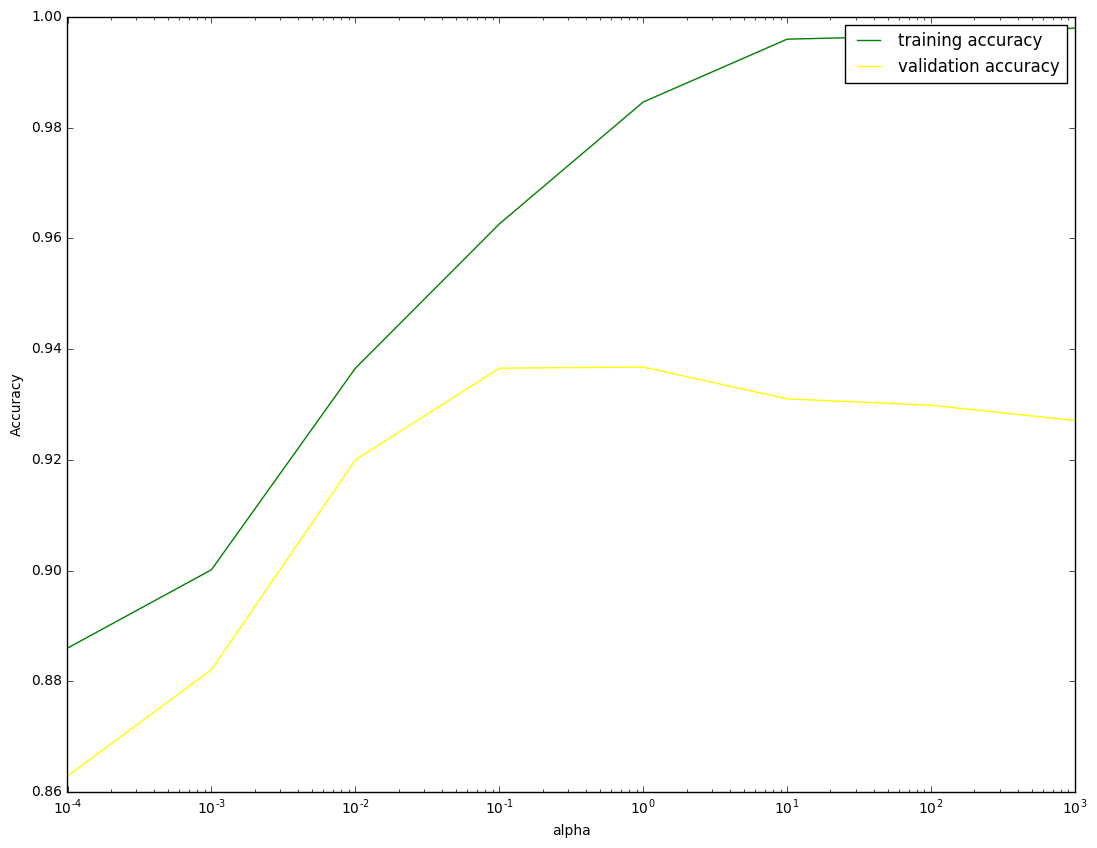

In [44]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.plot(neighbors_settings, bow_lgr_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, bow_lgr_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [45]:
bow_lgr=LogisticRegression(C=best_c)
bow_lgr.fit(BoW_dict['X_train_vect'],Y_train)
bow_test_proba = bow_lgr.predict_proba(BoW_dict['X_test_vect'])
bow_train_proba = bow_lgr.predict_proba(BoW_dict['X_train_vect'])
bow_test_proba

array([[  4.26960884e-04,   9.99573039e-01],
       [  9.93004886e-01,   6.99511421e-03],
       [  7.98954078e-06,   9.99992010e-01],
       ..., 
       [  6.80476777e-02,   9.31952322e-01],
       [  3.76795352e-04,   9.99623205e-01],
       [  9.42603030e-01,   5.73969696e-02]])

In [46]:
bow_fpr_train, bow_tpr_train, _ = roc_curve(Y_train, bow_train_proba[:, 1])
bow_fpr_test, bow_tpr_test, _ = roc_curve(Y_test, bow_test_proba[:, 1])
bow_test_auc = auc(bow_fpr_test, bow_tpr_test)
bow_train_auc = auc(bow_fpr_train, bow_tpr_train)
print(bow_test_auc)
print(bow_train_auc)

0.953215063371
0.996171579546


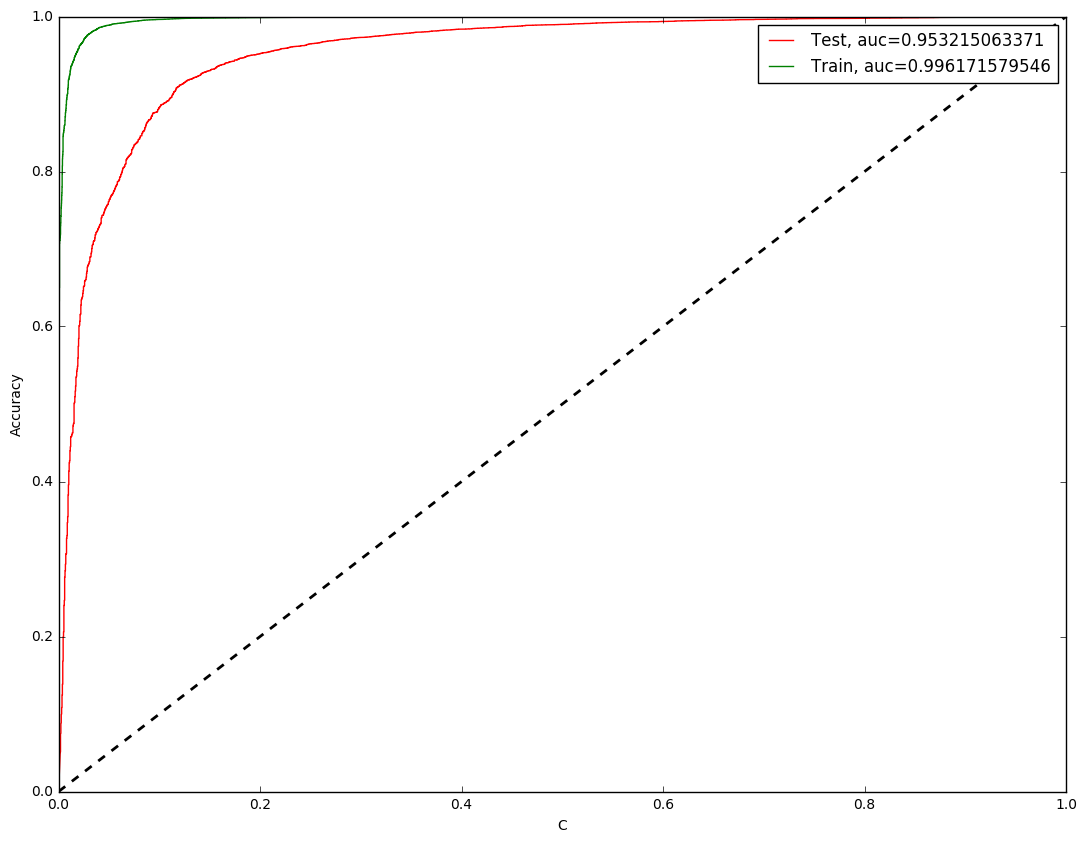

In [47]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(bow_fpr_test, bow_tpr_test, label="Test, auc="+str(bow_test_auc), color = 'red')
plt.plot(bow_fpr_train, bow_tpr_train, label="Train, auc="+str(bow_train_auc), color = 'green')

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [48]:
#https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c
neg_features_labels = []
neg_features_coeff = []
neg_features_feat = []

pos_features_labels = []
pos_features_coeff = []
pos_features_feat = []
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        neg_features_labels.append(class_labels[0])
        neg_features_coeff.append(coef)
        neg_features_feat.append(feat)
    
    for coef, feat in reversed(topn_class2):
        pos_features_labels.append(class_labels[1])
        pos_features_coeff.append(coef)
        pos_features_feat.append(feat)
        
    neg_df = pd.DataFrame({'Labels': neg_features_labels,'Coeff':neg_features_coeff ,'Negative features':neg_features_feat})
    pos_df = pd.DataFrame({'Labels': pos_features_labels,'Coeff':pos_features_coeff ,'Positive features':pos_features_feat})
    print("Top 10 featues for negative class \n", neg_df)
    print("Top 10 featues for positive class \n", pos_df)
    
f = most_informative_feature_for_binary_classification(count_vect, bow_lgr)

Top 10 featues for negative class 
       Coeff  Labels Negative features
0 -3.490639       0             worst
1 -2.664678       0     disappointing
2 -2.404860       0          terrible
3 -2.373635       0             awful
4 -2.362535       0             hopes
5 -2.276397       0              yuck
6 -2.269994       0           sounded
7 -2.223299       0             threw
8 -2.213603       0          horrible
9 -2.070526       0             bland
Top 10 featues for positive class 
       Coeff  Labels Positive features
0  2.497568       1               yum
1  2.468138       1         addictive
2  2.111907       1         delicious
3  2.079243       1        pleasantly
4  2.026213       1         excellent
5  2.025231       1             yummy
6  1.918579       1           perfect
7  1.917303       1              beat
8  1.870885       1           amazing
9  1.857614       1             loves


In [49]:
bow_test_conf = bow_lgr.predict(BoW_dict['X_test_vect'])

In [52]:
bow_train_conf = bow_lgr.predict(BoW_dict['X_train_vect'])

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
bow_train_conf_matrix = confusion_matrix(Y_train, bow_train_conf)
bow_test_conf_matrix = confusion_matrix(Y_test, bow_test_conf)
class_report = classification_report(Y_test, bow_test_conf)
print(bow_test_conf_matrix)
print(class_report)

[[ 1890   786]
 [  479 16845]]
             precision    recall  f1-score   support

          0       0.80      0.71      0.75      2676
          1       0.96      0.97      0.96     17324

avg / total       0.93      0.94      0.94     20000



[<matplotlib.text.Text at 0x7a5d8d30>, <matplotlib.text.Text at 0x7a5bcac8>]

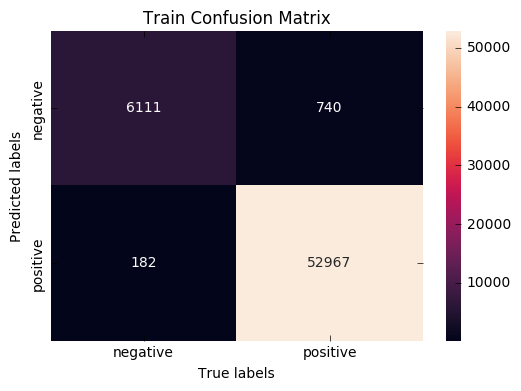

In [54]:
ax= plt.subplot()
sns.heatmap(bow_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

[<matplotlib.text.Text at 0x79fef7b8>, <matplotlib.text.Text at 0x7a4359b0>]

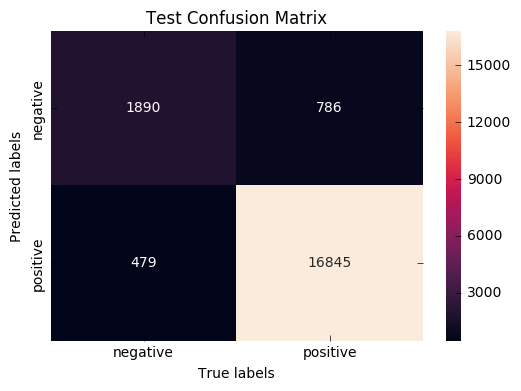

In [55]:
ax= plt.subplot()
sns.heatmap(bow_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

# Logistic Regression on TF-IDF

In [56]:
import pickle
with open(r"tf_idf.pkl", "rb") as input_file:
    tfidf_dict = pickle.load(input_file)

In [57]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

tfidf_lgr_train_score_list = []
tfidf_lgr_val_score_list = []
for c_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    tfidf_lgr=LogisticRegression(C=c_value)
    tfidf_lgr.fit(tfidf_dict['train_tf_idf'],Y_train)
    
    tfidf_lgr_train_score = tfidf_lgr.score(tfidf_dict['train_tf_idf'], Y_train)
    tfidf_lgr_train_score_list.append(tfidf_lgr_train_score)
    tfidf_lgr_val_score = tfidf_lgr.score(tfidf_dict['cv_tf_idf'], Y_val)
    tfidf_lgr_val_score_list.append(tfidf_lgr_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
tfidf_train_score = dict(zip(c_all, tfidf_lgr_train_score_list))
tfidf_val_score = dict(zip(c_all, tfidf_lgr_val_score_list))
print(tfidf_train_score)
print(tfidf_val_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.14s/it]


{0.1: 0.89926666666666666, 1: 0.95561666666666667, 100: 0.99983333333333335, 1000: 0.99993333333333334, 0.0001: 0.8858166666666667, 10: 0.99199999999999999, 0.01: 0.8858166666666667, 0.001: 0.8858166666666667}
{0.1: 0.87970000000000004, 1: 0.93369999999999997, 100: 0.94474999999999998, 1000: 0.94379999999999997, 0.0001: 0.86280000000000001, 10: 0.94574999999999998, 0.01: 0.86280000000000001, 0.001: 0.86280000000000001}


In [58]:
tfidf_best_c = max(tfidf_val_score, key=tfidf_val_score.get)
tfidf_best_c

10

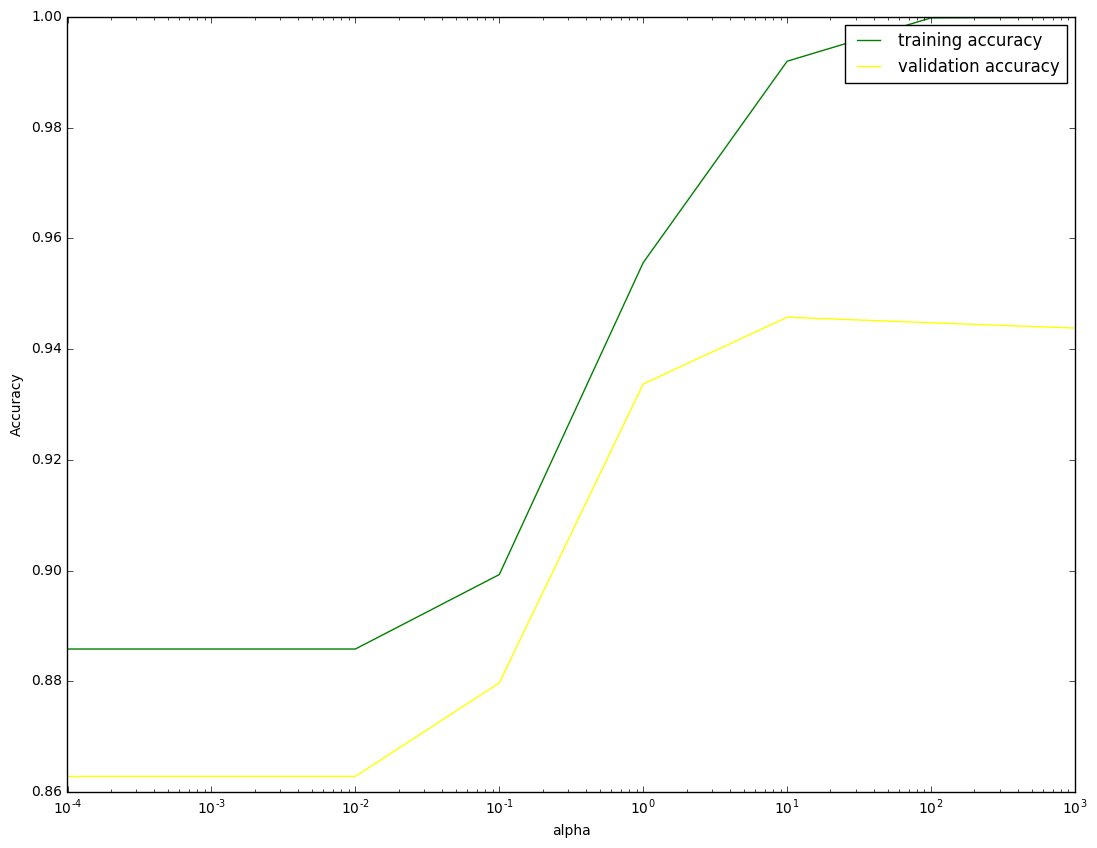

In [59]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.plot(neighbors_settings, tfidf_lgr_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, tfidf_lgr_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [60]:
#https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c
neg_features_labels = []
neg_features_coeff = []
neg_features_feat = []

pos_features_labels = []
pos_features_coeff = []
pos_features_feat = []
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        neg_features_labels.append(class_labels[0])
        neg_features_coeff.append(coef)
        neg_features_feat.append(feat)
    
    for coef, feat in reversed(topn_class2):
        pos_features_labels.append(class_labels[1])
        pos_features_coeff.append(coef)
        pos_features_feat.append(feat)
        
    neg_df = pd.DataFrame({'Labels': neg_features_labels,'Coeff':neg_features_coeff ,'Negative features':neg_features_feat})
    pos_df = pd.DataFrame({'Labels': pos_features_labels,'Coeff':pos_features_coeff ,'Positive features':pos_features_feat})
    print("Top 10 featues for negative class \n", neg_df)
    print("Top 10 featues for positive class \n", pos_df)
    
f = most_informative_feature_for_binary_classification(tf_idf_vect, tfidf_lgr)

Top 10 featues for negative class 
        Coeff  Labels Negative features
0 -34.732022       0         not worth
1 -33.231000       0             worst
2 -33.048806       0      disappointed
3 -27.741065       0     disappointing
4 -26.608546       0             bland
5 -26.125038       0               not
6 -25.933319       0          not good
7 -25.231868       0     not recommend
8 -23.450598       0         not great
9 -23.385146       0          horrible
Top 10 featues for positive class 
        Coeff  Labels Positive features
0  44.037258       1             great
1  35.656608       1              best
2  31.602408       1              good
3  30.191897       1         delicious
4  29.875450       1         excellent
5  29.063318       1  not disappointed
6  27.723844       1             loves
7  27.328193       1           perfect
8  27.234947       1             tasty
9  26.417494       1         wonderful


In [61]:
tfidf_lgr=LogisticRegression(C=tfidf_best_c)
tfidf_lgr.fit(tfidf_dict['train_tf_idf'], Y_train)
tfidf_test_proba = tfidf_lgr.predict_proba(tfidf_dict['test_tf_idf'])
tfidf_train_proba = tfidf_lgr.predict_proba(tfidf_dict['train_tf_idf'])
tfidf_test_proba

array([[  2.67883578e-04,   9.99732116e-01],
       [  9.44307107e-01,   5.56928926e-02],
       [  9.83593080e-03,   9.90164069e-01],
       ..., 
       [  2.22213318e-01,   7.77786682e-01],
       [  5.25454493e-05,   9.99947455e-01],
       [  9.88128111e-01,   1.18718887e-02]])

In [62]:
tfidf_fpr_train, tfidf_tpr_train, _ = roc_curve(Y_train, tfidf_train_proba[:, 1])
tfidf_fpr_test, tfidf_tpr_test, _ = roc_curve(Y_test, tfidf_test_proba[:, 1])
tfidf_test_auc = auc(tfidf_fpr_test, tfidf_tpr_test)
tfidf_train_auc = auc(tfidf_fpr_train, tfidf_tpr_train)
print(tfidf_test_auc)
print(tfidf_train_auc)

0.975524700434
0.9990490487


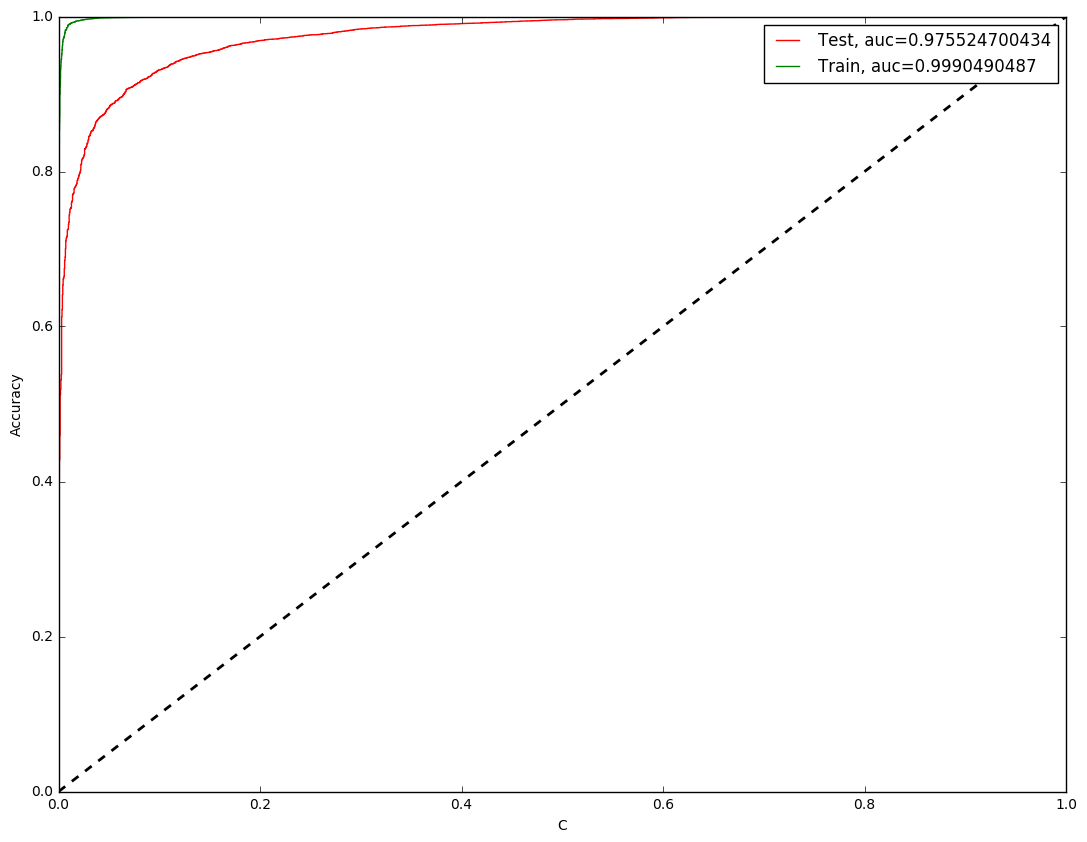

In [63]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(tfidf_fpr_test, tfidf_tpr_test, label="Test, auc="+str(tfidf_test_auc), color = 'red')
plt.plot(tfidf_fpr_train, tfidf_tpr_train, label="Train, auc="+str(tfidf_train_auc), color = 'green')

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [64]:
tfidf_test_conf = tfidf_lgr.predict(tfidf_dict['test_tf_idf'])

In [65]:
tfidf_train_conf = tfidf_lgr.predict(tfidf_dict['train_tf_idf'])

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
tfidf_test_conf_matrix = confusion_matrix(Y_test, tfidf_test_conf)
tfidf_train_conf_matrix = confusion_matrix(Y_train, tfidf_train_conf)
class_report = classification_report(Y_test, tfidf_test_conf)
print(tfidf_test_conf_matrix)
print(class_report)

[[ 1912   764]
 [  323 17001]]
             precision    recall  f1-score   support

          0       0.86      0.71      0.78      2676
          1       0.96      0.98      0.97     17324

avg / total       0.94      0.95      0.94     20000



[<matplotlib.text.Text at 0x7b313400>, <matplotlib.text.Text at 0x7b31c4a8>]

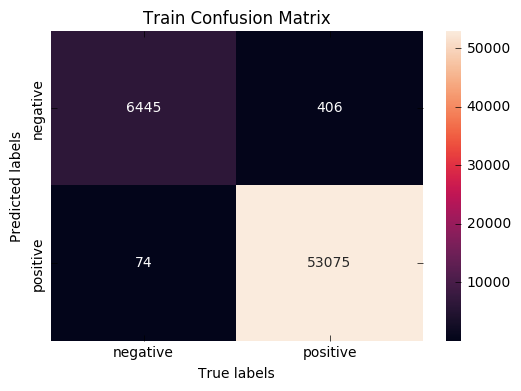

In [67]:
ax= plt.subplot()
sns.heatmap(tfidf_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

[<matplotlib.text.Text at 0x7b43c978>, <matplotlib.text.Text at 0x7b449b70>]

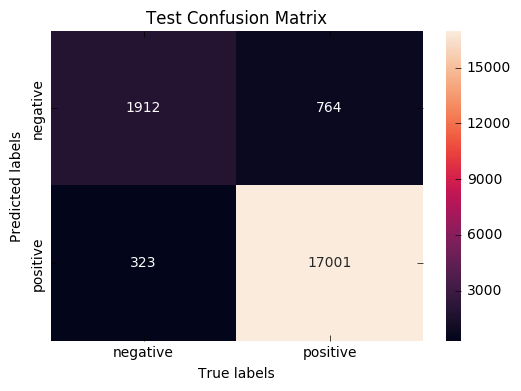

In [68]:
ax= plt.subplot()
sns.heatmap(tfidf_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

# Logistic Regression on Avg-tfidf

In [70]:
import pickle
with open(r"avg_w2v.pkl", "rb") as input_file:
    avg_tfidf_dict = pickle.load(input_file)

In [72]:
from sklearn.linear_model import LogisticRegression

avgtfidf_lgr_train_score_list = []
avgtfidf_lgr_val_score_list = []
for c_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    avgtfidf_lgr=LogisticRegression(C=c_value)
    avgtfidf_lgr.fit(avg_tfidf_dict['X_train_avgw2v'],Y_train)
    
    avgtfidf_lgr_train_score = avgtfidf_lgr.score(avg_tfidf_dict['X_train_avgw2v'], Y_train)
    avgtfidf_lgr_train_score_list.append(avgtfidf_lgr_train_score)
    avgtfidf_lgr_val_score = avgtfidf_lgr.score(avg_tfidf_dict['X_val_avgw2v'], Y_val)
    avgtfidf_lgr_val_score_list.append(avgtfidf_lgr_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
avgtfidf_train_score = dict(zip(c_all, avgtfidf_lgr_train_score_list))
avgtfidf_val_score = dict(zip(c_all, avgtfidf_lgr_val_score_list))
print(avgtfidf_train_score)
print(avgtfidf_val_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


{0.1: 0.91835, 1: 0.91843333333333332, 100: 0.91828333333333334, 1000: 0.91828333333333334, 0.0001: 0.8857666666666667, 10: 0.91825000000000001, 0.01: 0.91666666666666663, 0.001: 0.89893333333333336}
{0.1: 0.90815000000000001, 1: 0.90800000000000003, 100: 0.90785000000000005, 1000: 0.90785000000000005, 0.0001: 0.86280000000000001, 10: 0.90790000000000004, 0.01: 0.90525, 0.001: 0.87939999999999996}


In [73]:
best_c = max(avgtfidf_val_score, key=avgtfidf_val_score.get)
best_c

0.1

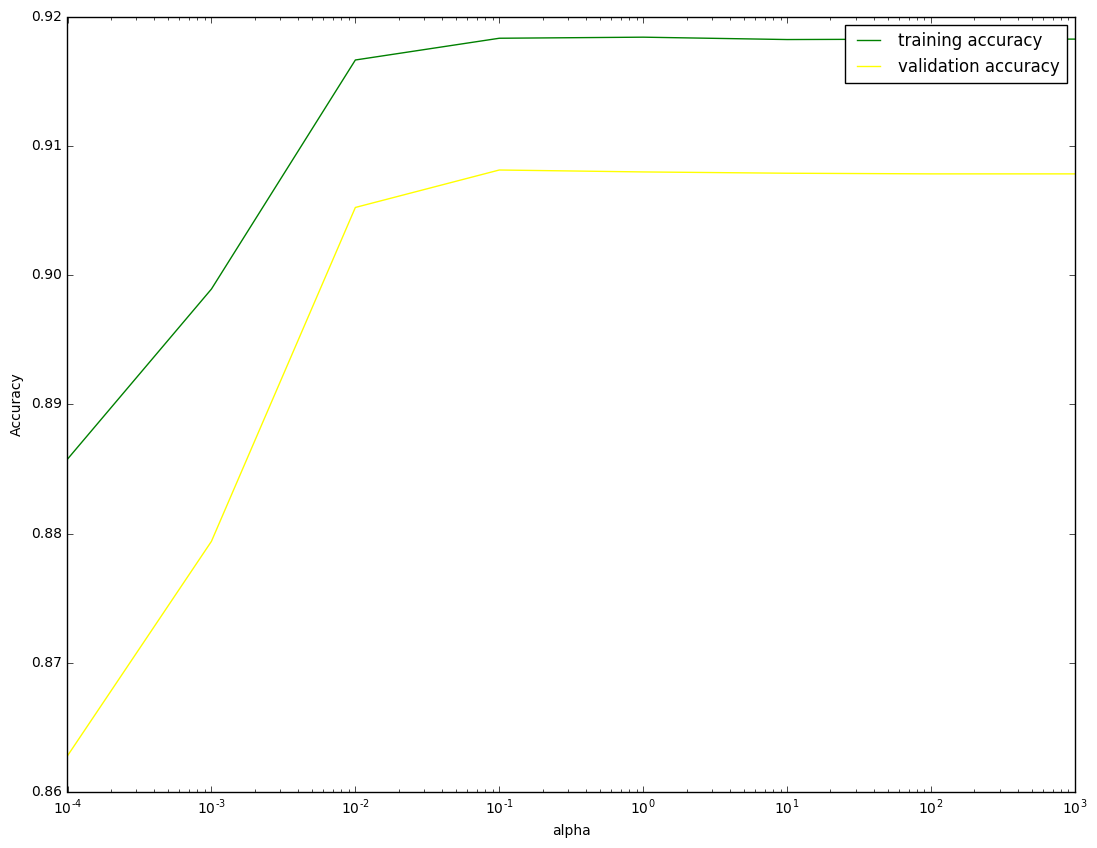

In [74]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.plot(neighbors_settings, avgtfidf_lgr_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, avgtfidf_lgr_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [75]:
avgtfidf_lgr=LogisticRegression(C=best_c)
avgtfidf_lgr.fit(avg_tfidf_dict['X_train_avgw2v'],Y_train)
avgtfidf_test_proba = avgtfidf_lgr.predict_proba(avg_tfidf_dict['X_test_avgw2v'])
avgtfidf_train_proba = avgtfidf_lgr.predict_proba(avg_tfidf_dict['X_train_avgw2v'])
avgtfidf_test_proba

array([[  1.48373424e-03,   9.98516266e-01],
       [  9.15794492e-01,   8.42055077e-02],
       [  2.09498466e-02,   9.79050153e-01],
       ..., 
       [  1.00856340e-01,   8.99143660e-01],
       [  5.68489727e-06,   9.99994315e-01],
       [  1.93096158e-01,   8.06903842e-01]])

In [76]:
avgtfidf_fpr_train, avgtfidf_tpr_train, _ = roc_curve(Y_train, bow_train_proba[:, 1])
avgtfidf_fpr_test, avgtfidf_tpr_test, _ = roc_curve(Y_test, bow_test_proba[:, 1])
avgtfidf_test_auc = auc(avgtfidf_fpr_test, avgtfidf_tpr_test)
avgtfidf_train_auc = auc(avgtfidf_fpr_train, avgtfidf_tpr_train)
print(avgtfidf_test_auc)
print(avgtfidf_train_auc)

0.953215063371
0.996171579546


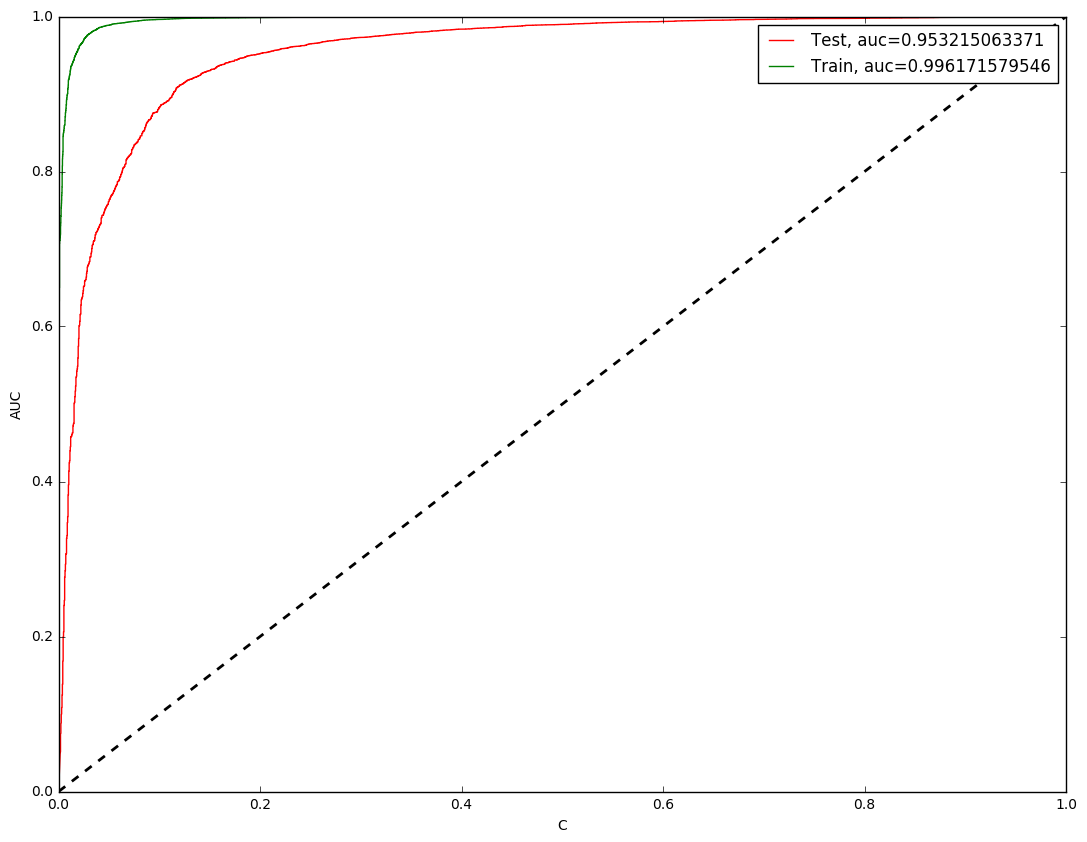

In [77]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(bow_fpr_test, avgtfidf_tpr_test, label="Test, auc="+str(avgtfidf_test_auc), color = 'red')
plt.plot(bow_fpr_train, avgtfidf_tpr_train, label="Train, auc="+str(avgtfidf_train_auc), color = 'green')

plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()

plt.show()